<a href="https://colab.research.google.com/github/JaleelSavoy/DeepLearningProjects/blob/master/DeepDishLearnerAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep (Dish) Learning 
### Classifying Images of Two Pizza Styles Using Transfer Learning with ResNet34
#### By Jaleel Walter Henry Savoy, inspired by Fast.ai Lessons 1 and 2

## Introduction
The objective of this analysis is to correctly classify two types of pizza categories, Chicago Deep Dish and New York Style. Both styles of pizza have a long history and very passionate supporters. You can learn more about the rivalry and differences between the styles by checking out the links below:
* [The differences between the styles](http://pizza.com/chicago-style-pizza-vs-new-york-style-pizza)
* [NY'er Review of Chicago Deep Pizza ](https://www.metro.us/news/todays-debate/chicago-deep-dish-vs-new-york-slice)
* [BuzzFeed Article Comparing the Styles](https://www.buzzfeed.com/mackenziekruvant/chicago-deep-dish-pizza-vs-nyc-style-pizza)

To accompish this goal, I will be using a convolutional neural network (CNN), but instead of training one from scratch I will use the ResNet-34 CNN, which was already trained on more than 1 million ImageNet images to accurately classify 1000 object categories. The ResNet-34 model will serve as a starting point for our objective to classify these two pizza styles, and it will allow me to train an accurate model very, very quickly and with a relatively small number of images. To train the model Google Colab was used because it's notebooks come with free GPU processing.

## Sourcing the Data & Preparing it for the Model
The images used for the training and validation of the model were sourced from Google Images. Ideally, the search queries should be clear and fairly specific in order to mitigate the risk of generating a bad image data set. My queries are below:
```
"chicago" + "deep dish" + "pizza" lou malnatis giordanos pizanos -"new york" -"pan" -"detroit" -tavern
```

```
"new york" "pizza" -"deep dish"
```

To retrieve the image URLs from each search query (which are used to download the images) I ran a simple line of JavaScript:
``` Javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join(',\n')));
```
The downloaded image URLs files were renamed **"urls_DeepDish.csv"** and **"urls_NewYorkStyle.csv"** and then uploaded to sub-folders in the Google Drive project folder named after the chosen class names, **"DeepDish"** and **"NewYorkStyle"**. The project folder is then mounted to Google Colab in order to be used by the notebook.

The URLs are then used to download the actual images and the Fast.ai library is used to prepare the images for use by the model. There are 107 images to be used for training, 35 images to be used for validation, which amounts to a 75%-25% split of the data.

In [82]:
### Mount Drive To Access Downloaded Image URLs
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
### Import Fast.ai Libraries & set the path to our Google Drive Project Folder
from fastai import *
from fastai.vision import *
import os

path = Path('/content/drive/My Drive/DeepDishLearner')
os.chdir(path)
!ls

DeepDish  models  NewYorkStyle


In [0]:
classes = ['DeepDish', 'NewYorkStyle']

In [0]:
### Download the actual images of Deep Dish pizza
folder = "DeepDish"
file = "urls_DeepDish.csv"
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(dest/file, dest, max_pics=200)

In [0]:
### Download the actual images of New York Style pizza
folder = "NewYorkStyle"
file = "urls_NewYorkStyle.csv"
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(dest/file, dest, max_pics=200)

In [0]:
### Verify the images downloaded and remove ones that cannot be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

['DeepDish', 'NewYorkStyle']


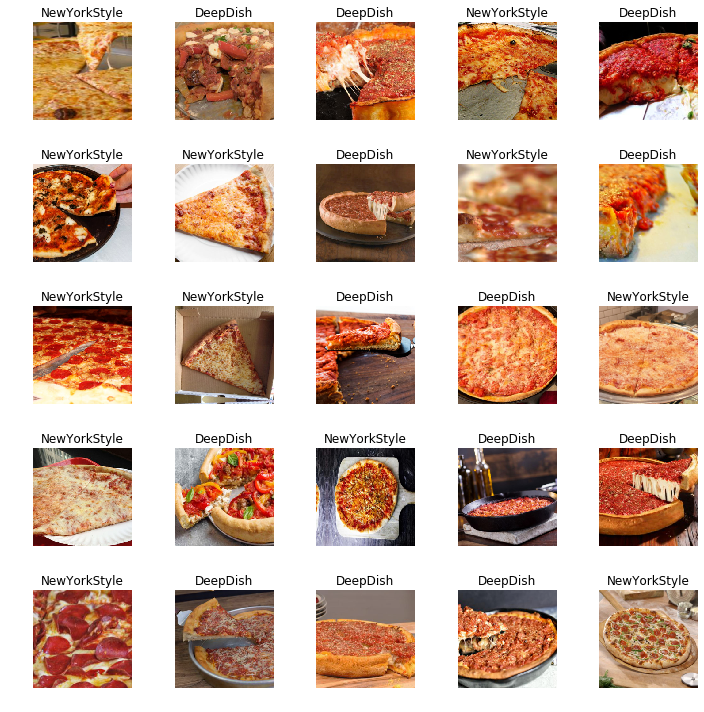

In [65]:
### Create an ImageDataBunch for the model and view the data
np.random.seed(42)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  valid_pct=0.25,
                                  ds_tfms=get_transforms(),
                                  size=224,
                                  num_workers=4).normalize(imagenet_stats)
print(data.classes)
data.show_batch(rows=5, figsize=(10,10))

In [66]:
### Size of training dataset, the validation data set, and the number classes
len(data.train_ds), len(data.valid_ds), data.c

(107, 35, 2)

## Training the Model
Now that the actual images are downloaded from their URLs and prepared, it can be used to train the model. As mentioned earlier, the pre-trained ResNet-34 CNN (from the Fast.ai library) will be used as the starting point to fit the pizza classifier. Initially, the default settings will be used and evaluated and then the model will be tuned to address any deficiencies in the training. To monitoring the training process, the error rate will be printed out and after fitting the confusion matrix will be assessed.

For the initial training cycle, we will only be training the coefficients of the last layer of the neural network. 

In [70]:
### Initialize the ResNet-34 Model and Choose the Error Rate for Monitoring
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

### Train on the Pizza Images using 1-cycle policy and 4 Epochs
learn.fit_one_cycle(7)

epoch,train_loss,valid_loss,error_rate,time
0,0.983015,0.670051,0.428571,00:03
1,0.835389,0.585984,0.371429,00:02
2,0.764803,0.627903,0.371429,00:02
3,0.667577,0.693310,0.371429,00:02
4,0.577346,0.700796,0.342857,00:02
5,0.518843,0.655864,0.314286,00:02
6,0.458963,0.620056,0.285714,00:02


We can see that the model is improving, but the model still seems a bit underfitted. One way to address this is to train on more epochs.

In [0]:
### Save the Weights from the Initial Training
learn.save('stage-1')

We make sure to save the weights from this initial training in case we need to later revert back to it or use them in some way.

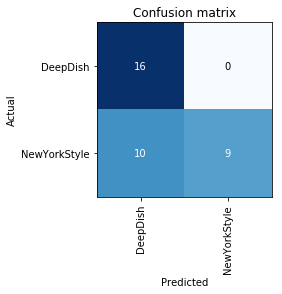

In [72]:
### Generate and Plot the Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The results of the model's classification performance on the test data is represented above as a confusion matrix. It is clear from the confusion matrix that there is much room for improvement, the model correctly classifies all of the Deep Dish pizza images, but misclassifies 10 of the 19 New York Style pizza images. This should improve once the model is better fitted to the data.

### Training All Layers
Now we will unfreeze the rest of the model's layers and train them all using our training images.

In [73]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


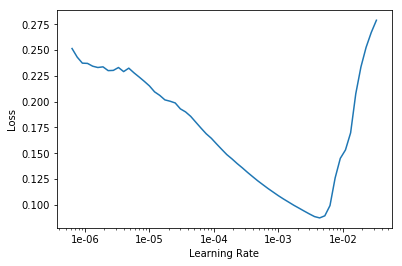

In [74]:
learn.recorder.plot()

Using the learning rate finder method, we can see that the around 1e-5 the loss value is strongly sloping downward, which is a good sign. So 1e-5 will be the bottom learning rate and 1e-3 will be the top learning rate.

In [75]:
learn.fit_one_cycle(8, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.198977,0.593788,0.285714,00:02
1,0.197729,0.536744,0.228571,00:02
2,0.216924,0.470270,0.200000,00:02
3,0.200309,0.378534,0.200000,00:02
4,0.177646,0.310899,0.114286,00:02
5,0.167556,0.252851,0.085714,00:02
6,0.153090,0.207173,0.085714,00:02
7,0.138076,0.191871,0.085714,00:02


In [0]:
learn.save('stage-2')

The new results are much, much better than the results attained after the initial training of only the last layer. The misclassification rate dropped by 20% and the model is overall much better fit to the data.

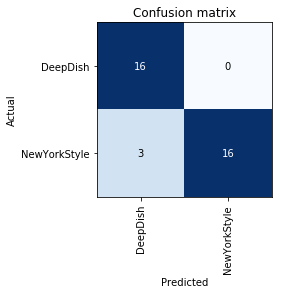

In [80]:
### Load the Weight from Most Recent Fit
learn.load('stage-2')

### Confusion Matrix from Test Performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We see from the new confusion matrix that 3 New York Style pizza images are still incorrectly classified as Deep Dish pizza. In order to get a better understanding of why the model is failing on these images, we will assess the images with the top losses.

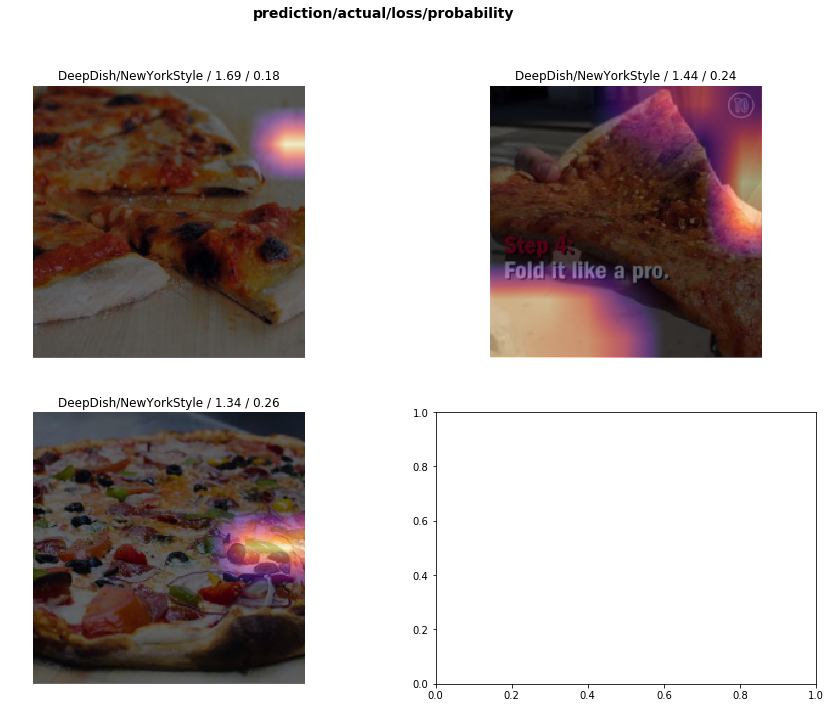

In [85]:
### See Where the Model Struggled Most
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(3, figsize=(15,11), heatmap=True)

Strangely, it seems the model to misclassified the images based on the background or surface on which the pizza is placed. This seems to indicate that the model overfit this feature and we should look into expanding our training set to include images of pizzas on a variety of surfaces so the model will better generalize. The third image seems to misclassify based on the toppings of the pizza, this relates to the last observation that the training data didn't cover a largest enough variety; the training set was made up of mostly plain cheese pizza, but there were a handful of pizza images that included toppings.